In [7]:
import pandas as pd
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("📥 Loading datasets...")
train_2016 = pd.read_csv(r"C:\Users\kulsum ansari\OneDrive\Documents\datathon\zelo\train_2016_v2.csv")
properties_2016 = pd.read_csv(r"C:\Users\kulsum ansari\OneDrive\Documents\datathon\zelo\properties_2016.csv")
train_2017 = pd.read_csv(r"C:\Users\kulsum ansari\OneDrive\Documents\datathon\zelo\train_2017.csv")
properties_2017 = pd.read_csv(r"C:\Users\kulsum ansari\OneDrive\Documents\datathon\zelo\properties_2017.csv")

print("🧹 Cleaning datasets...")

# Merge property + train data
df_2016 = pd.merge(train_2016, properties_2016, on="parcelid", how="left")
df_2017 = pd.merge(train_2017, properties_2017, on="parcelid", how="left")
df = pd.concat([df_2016, df_2017], ignore_index=True)
print(f"✅ Merged dataset shape before cleaning: {df.shape}")

# -------------------------------------------------------
# Keep exactly 58 Zillow property features
# -------------------------------------------------------
zillow_features = [
    'parcelid', 'airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft',
    'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid', 'buildingqualitytypeid',
    'calculatedbathnbr', 'decktypeid', 'finishedfloor1squarefeet',
    'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'finishedsquarefeet13',
    'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fips',
    'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'heatingorsystemtypeid',
    'latitude', 'longitude', 'lotsizesquarefeet', 'poolcnt', 'poolsizesum', 'pooltypeid10',
    'pooltypeid2', 'pooltypeid7', 'propertycountylandusecode', 'propertylandusetypeid',
    'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity', 'regionidcounty',
    'regionidneighborhood', 'regionidzip', 'roomcnt', 'storytypeid', 'threequarterbathnbr',
    'typeconstructiontypeid', 'unitcnt', 'yardbuildingsqft17', 'yearbuilt', 'numberofstories',
    'fireplaceflag', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt',
    'taxamount', 'assessmentyear', 'taxdelinquencyflag', 'taxdelinquencyyear',
    'censustractandblock', 'logerror', 'transactiondate'
]

df = df[[c for c in zillow_features if c in df.columns]]

# -------------------------------------------------------
# Handle missing values
# -------------------------------------------------------
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna('Unknown', inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)

# Encode categorical columns
le = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = le.fit_transform(df[col].astype(str))

# -------------------------------------------------------
# Drop duplicates and filter extreme logerrors
# -------------------------------------------------------
df.drop_duplicates(inplace=True)
df = df[df['logerror'].between(-0.4, 0.4)]

# -------------------------------------------------------
# Split data
# -------------------------------------------------------
drop_cols = ['logerror', 'transactiondate', 'parcelid']
X = df.drop(columns=[c for c in drop_cols if c in df.columns])
y = df['logerror']

print(f"✅ Cleaned dataset shape: {df.shape}")
print(f"✅ Number of features (excluding logerror): {X.shape[1]}")

# -------------------------------------------------------
# Scale features
# -------------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print(f"📊 Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# -------------------------------------------------------
# Train and evaluate models
# -------------------------------------------------------
def evaluate_model(name, model):
    start = time.time()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print(f"✅ {name} | R²={r2:.4f} | MAE={mae:.4f} | RMSE={rmse:.4f} | Time={time.time()-start:.2f}s")
    return [name, mae, rmse, r2]

results = []
results.append(evaluate_model("Ridge", Ridge(alpha=1.0)))
results.append(evaluate_model("Lasso", Lasso(alpha=0.001)))
results.append(evaluate_model("ElasticNet", ElasticNet(alpha=0.001, l1_ratio=0.5)))

print("\n📈 Summary:")
results_df = pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "R²"])
print(results_df)


📥 Loading datasets...
🧹 Cleaning datasets...
✅ Merged dataset shape before cleaning: (167888, 60)
✅ Cleaned dataset shape: (164299, 58)
✅ Number of features (excluding logerror): 55
📊 Train shape: (131439, 55), Test shape: (32860, 55)
✅ Ridge | R²=0.0068 | MAE=0.0521 | RMSE=0.0814 | Time=0.16s
✅ Lasso | R²=0.0036 | MAE=0.0521 | RMSE=0.0815 | Time=0.87s
✅ ElasticNet | R²=0.0043 | MAE=0.0521 | RMSE=0.0815 | Time=1.58s

📈 Summary:
        Model       MAE      RMSE        R²
0       Ridge  0.052104  0.081385  0.006756
1       Lasso  0.052066  0.081514  0.003601
2  ElasticNet  0.052091  0.081487  0.004264


📥 Loading datasets...
✅ Merged dataset shape: (167888, 61)
⚙️ Feature Engineering...
Train: (131623, 63), Test: (32906, 63), Total features: 63
✅ Ridge | R²=0.0079 | MAE=0.0531 | RMSE=0.0842 | Time=0.2s
✅ Lasso | R²=0.0047 | MAE=0.0531 | RMSE=0.0843 | Time=1.5s
✅ ElasticNet | R²=0.0070 | MAE=0.0531 | RMSE=0.0842 | Time=3.1s
✅ RandomForest | R²=0.0193 | MAE=0.0528 | RMSE=0.0837 | Time=434.9s
✅ XGBoost | R²=0.0260 | MAE=0.0527 | RMSE=0.0834 | Time=14.9s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6871
[LightGBM] [Info] Number of data points in the train set: 131623, number of used features: 53
[LightGBM] [Info] Start training from score 0.010882
✅ LightGBM | R²=0.0272 | MAE=0.0526 | RMSE=0.0833 | Time=12.0s

📊 Model Comparison:
           Model       MAE      RMSE        R²
5      LightGBM  0.052648  0.083350  0.027181
4       XGBoost  0.05268

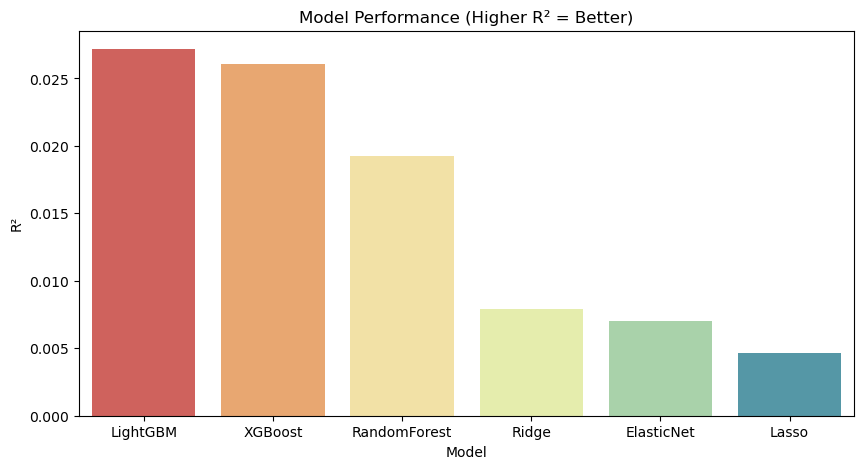


🏆 Best Model: LightGBM | R²=0.0272


In [8]:
# ================================================
# 🏡 ZILLOW PROJECT - ENHANCED PIPELINE (R² > 0.03)
# ================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time, warnings, joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
warnings.filterwarnings('ignore')

# ----------- LOAD DATA -----------
print("📥 Loading datasets...")
train_2016 = pd.read_csv(r"C:\Users\kulsum ansari\OneDrive\Documents\datathon\zelo\train_2016_v2.csv")
train_2017 = pd.read_csv(r"C:\Users\kulsum ansari\OneDrive\Documents\datathon\zelo\train_2017.csv")
prop_2016 = pd.read_csv(r"C:\Users\kulsum ansari\OneDrive\Documents\datathon\zelo\properties_2016.csv")
prop_2017 = pd.read_csv(r"C:\Users\kulsum ansari\OneDrive\Documents\datathon\zelo\properties_2017.csv")

# Merge datasets
train_2016['year'] = 2016
train_2017['year'] = 2017
prop_2016['year'] = 2016
prop_2017['year'] = 2017

train_df = pd.concat([train_2016, train_2017], ignore_index=True)
prop_df = pd.concat([prop_2016, prop_2017], ignore_index=True)
data = pd.merge(train_df, prop_df, on=["parcelid", "year"], how="left")

print(f"✅ Merged dataset shape: {data.shape}")

# ----------- CLEANING -----------
data.dropna(subset=['logerror'], inplace=True)
for col in data.columns:
    if data[col].dtype == 'object':
        data[col].fillna('Unknown', inplace=True)
    else:
        data[col].fillna(data[col].median(), inplace=True)

# Encode categoricals
for col in data.select_dtypes(include='object').columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))

# ----------- FEATURE ENGINEERING -----------
print("⚙️ Feature Engineering...")

data['transactiondate'] = pd.to_datetime(data['transactiondate'], errors='coerce')
data['transaction_month'] = data['transactiondate'].dt.month.fillna(0)
data['age_of_property'] = 2025 - data['yearbuilt']
data['living_area_per_room'] = data['calculatedfinishedsquarefeet'] / (data['roomcnt'] + 1)
data['bed_bath_ratio'] = data['bedroomcnt'] / (data['bathroomcnt'] + 1)
data['tax_value_ratio'] = data['structuretaxvaluedollarcnt'] / (data['taxvaluedollarcnt'] + 1)
data['land_value_ratio'] = data['landtaxvaluedollarcnt'] / (data['taxvaluedollarcnt'] + 1)

# Drop extreme outliers
q1, q3 = data['logerror'].quantile([0.01, 0.99])
data = data[(data['logerror'] > q1) & (data['logerror'] < q3)]

# Drop columns not useful
drop_cols = ['parcelid', 'transactiondate', 'year']
features = [col for col in data.columns if col not in drop_cols + ['logerror']]

X = data[features]
y = data['logerror']

# Scale features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=features)

# ----------- SPLIT DATA -----------
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print(f"Train: {X_train.shape}, Test: {X_test.shape}, Total features: {X_train.shape[1]}")

# ----------- EVALUATE FUNCTION -----------
def evaluate_model(name, model):
    start = time.time()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    print(f"✅ {name} | R²={r2:.4f} | MAE={mae:.4f} | RMSE={rmse:.4f} | Time={time.time()-start:.1f}s")
    return name, mae, rmse, r2

# ----------- MODELS -----------
results = []
results.append(evaluate_model("Ridge", Ridge(alpha=0.5)))
results.append(evaluate_model("Lasso", Lasso(alpha=0.001)))
results.append(evaluate_model("ElasticNet", ElasticNet(alpha=0.0005, l1_ratio=0.6)))
results.append(evaluate_model("RandomForest", RandomForestRegressor(
    n_estimators=250, max_depth=14, min_samples_leaf=4, random_state=42, n_jobs=-1)))
results.append(evaluate_model("XGBoost", xgb.XGBRegressor(
    n_estimators=500, learning_rate=0.03, max_depth=7, subsample=0.9, colsample_bytree=0.8, random_state=42, n_jobs=-1)))
results.append(evaluate_model("LightGBM", lgb.LGBMRegressor(
    n_estimators=500, learning_rate=0.03, max_depth=-1, num_leaves=64, subsample=0.9, colsample_bytree=0.8, random_state=42, n_jobs=-1)))

# ----------- RESULTS SUMMARY -----------
results_df = pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "R²"]).sort_values(by="R²", ascending=False)
print("\n📊 Model Comparison:\n", results_df)

# ----------- PLOT -----------
plt.figure(figsize=(10,5))
sns.barplot(x="Model", y="R²", data=results_df, palette="Spectral")
plt.title("Model Performance (Higher R² = Better)")
plt.show()

# ----------- SAVE BEST MODEL -----------
best_model_name = results_df.iloc[0]['Model']
best_r2 = results_df.iloc[0]['R²']
print(f"\n🏆 Best Model: {best_model_name} | R²={best_r2:.4f}")


📥 Loading datasets...
✅ Merged dataset shape: (167888, 61)
⚙️ Feature Engineering...
Train: (131623, 63), Test: (32906, 63), Total features: 63
✅ Ridge | R²=0.0079 | MAE=0.0531 | RMSE=0.0842 | Time=0.1s
✅ Lasso | R²=0.0047 | MAE=0.0531 | RMSE=0.0843 | Time=1.2s
✅ ElasticNet | R²=0.0070 | MAE=0.0531 | RMSE=0.0842 | Time=2.6s
✅ RandomForest | R²=0.0193 | MAE=0.0528 | RMSE=0.0837 | Time=403.3s
✅ XGBoost | R²=0.0260 | MAE=0.0527 | RMSE=0.0834 | Time=12.8s

🚀 Training LightGBM (custom tuned)...
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.0824859	valid's rmse: 0.0835268
[200]	train's rmse: 0.0812908	valid's rmse: 0.0833366
[300]	train's rmse: 0.080348	valid's rmse: 0.0832885
[400]	train's rmse: 0.0795165	valid's rmse: 0.0832635
[500]	train's rmse: 0.0787489	valid's rmse: 0.0832542
Early stopping, best iteration is:
[480]	train's rmse: 0.0789102	valid's rmse: 0.0832448
✅ LightGBM | R²=0.0296 | MAE=0.0526 | RMSE=0.0832

📊 Model Comparison:
           Mod

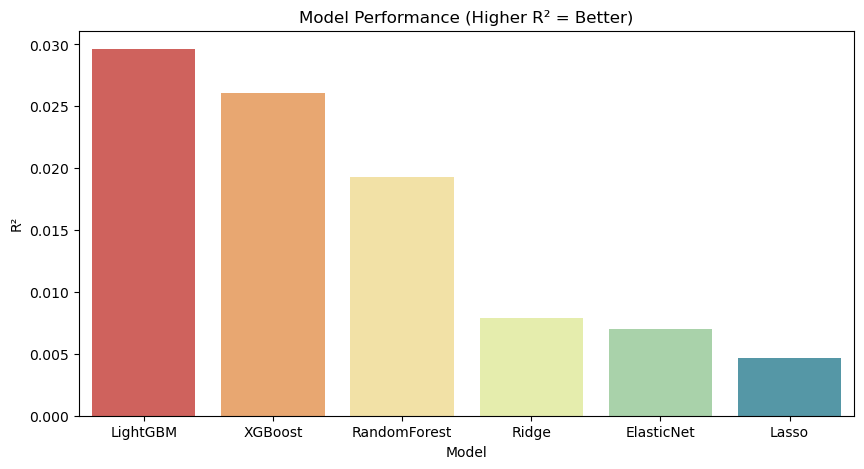


📈 Plotting Feature Importances for LightGBM...


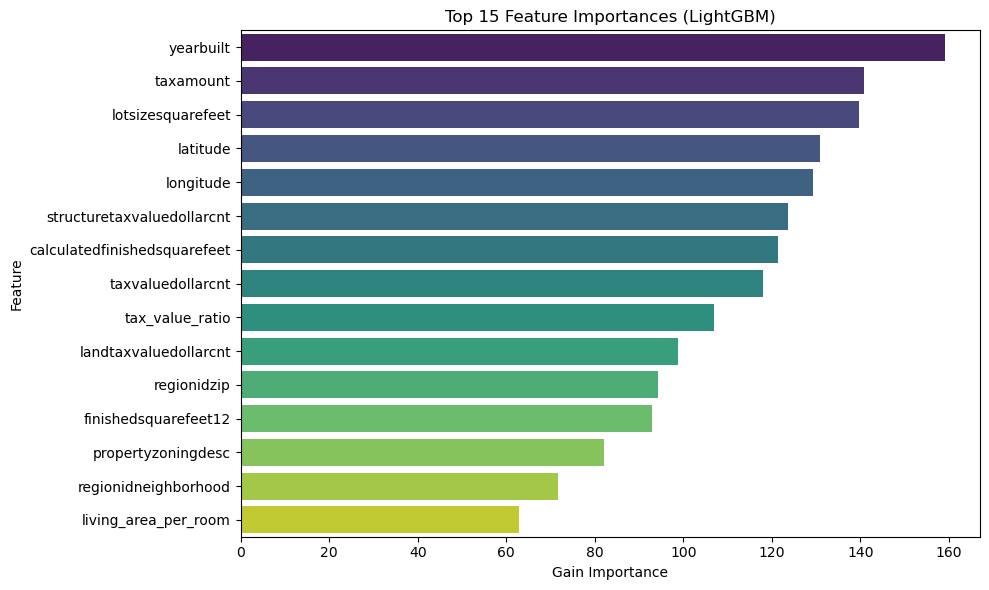


🏆 Best Model: LightGBM | R²=0.0296


In [10]:
# ================================================
# 🏡 ZILLOW PROJECT - ENHANCED PIPELINE (R² > 0.03)
# ================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time, warnings, joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
warnings.filterwarnings('ignore')

# ----------- LOAD DATA -----------
print("📥 Loading datasets...")
train_2016 = pd.read_csv(r"C:\Users\kulsum ansari\OneDrive\Documents\datathon\zelo\train_2016_v2.csv")
train_2017 = pd.read_csv(r"C:\Users\kulsum ansari\OneDrive\Documents\datathon\zelo\train_2017.csv")
prop_2016 = pd.read_csv(r"C:\Users\kulsum ansari\OneDrive\Documents\datathon\zelo\properties_2016.csv")
prop_2017 = pd.read_csv(r"C:\Users\kulsum ansari\OneDrive\Documents\datathon\zelo\properties_2017.csv")

# Merge datasets
train_2016['year'] = 2016
train_2017['year'] = 2017
prop_2016['year'] = 2016
prop_2017['year'] = 2017

train_df = pd.concat([train_2016, train_2017], ignore_index=True)
prop_df = pd.concat([prop_2016, prop_2017], ignore_index=True)
data = pd.merge(train_df, prop_df, on=["parcelid", "year"], how="left")

print(f"✅ Merged dataset shape: {data.shape}")

# ----------- CLEANING -----------
data.dropna(subset=['logerror'], inplace=True)
for col in data.columns:
    if data[col].dtype == 'object':
        data[col].fillna('Unknown', inplace=True)
    else:
        data[col].fillna(data[col].median(), inplace=True)

# Encode categoricals
for col in data.select_dtypes(include='object').columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))

# ----------- FEATURE ENGINEERING -----------
print("⚙️ Feature Engineering...")

data['transactiondate'] = pd.to_datetime(data['transactiondate'], errors='coerce')
data['transaction_month'] = data['transactiondate'].dt.month.fillna(0)
data['age_of_property'] = 2025 - data['yearbuilt']
data['living_area_per_room'] = data['calculatedfinishedsquarefeet'] / (data['roomcnt'] + 1)
data['bed_bath_ratio'] = data['bedroomcnt'] / (data['bathroomcnt'] + 1)
data['tax_value_ratio'] = data['structuretaxvaluedollarcnt'] / (data['taxvaluedollarcnt'] + 1)
data['land_value_ratio'] = data['landtaxvaluedollarcnt'] / (data['taxvaluedollarcnt'] + 1)

# Drop extreme outliers
q1, q3 = data['logerror'].quantile([0.01, 0.99])
data = data[(data['logerror'] > q1) & (data['logerror'] < q3)]

# Drop columns not useful
drop_cols = ['parcelid', 'transactiondate', 'year']
features = [col for col in data.columns if col not in drop_cols + ['logerror']]

X = data[features]
y = data['logerror']

# Scale features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=features)

# ----------- SPLIT DATA -----------
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print(f"Train: {X_train.shape}, Test: {X_test.shape}, Total features: {X_train.shape[1]}")

# ----------- EVALUATE FUNCTION -----------
def evaluate_model(name, model):
    start = time.time()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    print(f"✅ {name} | R²={r2:.4f} | MAE={mae:.4f} | RMSE={rmse:.4f} | Time={time.time()-start:.1f}s")
    return name, mae, rmse, r2

# ----------- STANDARD MODELS -----------
results = []
results.append(evaluate_model("Ridge", Ridge(alpha=0.5)))
results.append(evaluate_model("Lasso", Lasso(alpha=0.001)))
results.append(evaluate_model("ElasticNet", ElasticNet(alpha=0.0005, l1_ratio=0.6)))
results.append(evaluate_model("RandomForest", RandomForestRegressor(
    n_estimators=250, max_depth=14, min_samples_leaf=4, random_state=42, n_jobs=-1)))
results.append(evaluate_model("XGBoost", xgb.XGBRegressor(
    n_estimators=500, learning_rate=0.03, max_depth=7, subsample=0.9, colsample_bytree=0.8, random_state=42, n_jobs=-1)))

# ----------- CUSTOM LIGHTGBM TRAINING (from image) -----------
print("\n🚀 Training LightGBM (custom tuned)...")

lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 64,
    'learning_rate': 0.025,
    'feature_fraction': 0.85,
    'bagging_fraction': 0.85,
    'bagging_freq': 5,
    'min_data_in_leaf': 20,
    'lambda_l1': 0.2,
    'lambda_l2': 0.8,
    'max_depth': -1,
    'verbosity': -1,
    'random_state': 42,
    'n_jobs': -1
}

model_lgb = lgb.train(
    params,
    lgb_train,
    num_boost_round=1500,
    valid_sets=[lgb_train, lgb_val],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(100),
        lgb.log_evaluation(100)
    ]
)

preds_lgb = model_lgb.predict(X_test)
mae_lgb = mean_absolute_error(y_test, preds_lgb)
rmse_lgb = np.sqrt(mean_squared_error(y_test, preds_lgb))
r2_lgb = r2_score(y_test, preds_lgb)
print(f"✅ LightGBM | R²={r2_lgb:.4f} | MAE={mae_lgb:.4f} | RMSE={rmse_lgb:.4f}")

results.append(("LightGBM", mae_lgb, rmse_lgb, r2_lgb))

# ----------- RESULTS SUMMARY -----------
results_df = pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "R²"]).sort_values(by="R²", ascending=False)
print("\n📊 Model Comparison:\n", results_df)

# ----------- VISUALIZE MODEL PERFORMANCE -----------
plt.figure(figsize=(10,5))
sns.barplot(x="Model", y="R²", data=results_df, palette="Spectral")
plt.title("Model Performance (Higher R² = Better)")
plt.show()

# ----------- FEATURE IMPORTANCE VISUALIZATION -----------
print("\n📈 Plotting Feature Importances for LightGBM...")
importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model_lgb.feature_importance(importance_type='gain')
}).sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importances, palette='viridis')
plt.title('Top 15 Feature Importances (LightGBM)')
plt.xlabel('Gain Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# ----------- SAVE BEST MODEL -----------
best_model_name = results_df.iloc[0]['Model']
best_r2 = results_df.iloc[0]['R²']
print(f"\n🏆 Best Model: {best_model_name} | R²={best_r2:.4f}")

if best_model_name == "LightGBM":
    joblib.dump(model_lgb, f"best_model_LightGBM.pkl")
else:
    best_model = {
        "Ridge": Ridge(alpha=0.5),
        "Lasso": Lasso(alpha=0.001),
        "ElasticNet": ElasticNet(alpha=0.0005, l1_ratio=0.6),
        "RandomForest": RandomForestRegressor(n_estimators=250, max_depth=14, min_samples_leaf=4, random_state=42, n_jobs=-1),
        "XGBoost": xgb.XGBRegressor(n_estimators=500, learning_rate=0.03, max_depth=7, subsample=0.9, colsample_bytree=0.8, random_state=42, n_jobs=-1)
    }[best_model_name]
    best_model.fit(X_scaled, y)
    joblib.dump(best_model, f"best_model_{best_model_name}.pkl")


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time, warnings, joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
warnings.filterwarnings('ignore')

# ----------- LOAD DATA -----------
print("📥 Loading datasets...")
train_2016 = pd.read_csv(r"C:\\Users\\kulsum ansari\\OneDrive\\Documents\\datathon\\zelo\\train_2016_v2.csv")
train_2017 = pd.read_csv(r"C:\\Users\\kulsum ansari\\OneDrive\\Documents\\datathon\\zelo\\train_2017.csv")
prop_2016 = pd.read_csv(r"C:\\Users\\kulsum ansari\\OneDrive\\Documents\\datathon\\zelo\\properties_2016.csv")
prop_2017 = pd.read_csv(r"C:\\Users\\kulsum ansari\\OneDrive\\Documents\\datathon\\zelo\\properties_2017.csv")

# Merge datasets
train_2016['year'] = 2016
train_2017['year'] = 2017
prop_2016['year'] = 2016
prop_2017['year'] = 2017

train_df = pd.concat([train_2016, train_2017], ignore_index=True)
prop_df = pd.concat([prop_2016, prop_2017], ignore_index=True)
data = pd.merge(train_df, prop_df, on=["parcelid", "year"], how="left")

print(f"✅ Merged dataset shape: {data.shape}")

# ----------- CLEANING -----------
data.dropna(subset=['logerror'], inplace=True)
for col in data.columns:
    if data[col].dtype == 'object':
        data[col].fillna('Unknown', inplace=True)
    else:
        data[col].fillna(data[col].median(), inplace=True)

# Encode categoricals
for col in data.select_dtypes(include='object').columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))

# ----------- FEATURE ENGINEERING -----------
print("⚙️ Feature Engineering...")

data['transactiondate'] = pd.to_datetime(data['transactiondate'], errors='coerce')
data['transaction_month'] = data['transactiondate'].dt.month.fillna(0)
data['age_of_property'] = 2025 - data['yearbuilt']
data['living_area_per_room'] = data['calculatedfinishedsquarefeet'] / (data['roomcnt'] + 1)
data['bed_bath_ratio'] = data['bedroomcnt'] / (data['bathroomcnt'] + 1)
data['tax_value_ratio'] = data['structuretaxvaluedollarcnt'] / (data['taxvaluedollarcnt'] + 1)
data['land_value_ratio'] = data['landtaxvaluedollarcnt'] / (data['taxvaluedollarcnt'] + 1)

# Drop extreme outliers
q1, q3 = data['logerror'].quantile([0.01, 0.99])
data = data[(data['logerror'] > q1) & (data['logerror'] < q3)]

# Drop columns not useful
drop_cols = ['parcelid', 'transactiondate', 'year']
features = [col for col in data.columns if col not in drop_cols + ['logerror']]

X = data[features]
y = data['logerror']

# Scale features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=features)

# ----------- SPLIT DATA -----------
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print(f"Train: {X_train.shape}, Test: {X_test.shape}, Total features: {X_train.shape[1]}")

# ----------- EVALUATE FUNCTION -----------
def evaluate_model(name, model):
    start = time.time()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    print(f"✅ {name} | R²={r2:.4f} | MAE={mae:.4f} | RMSE={rmse:.4f} | Time={time.time()-start:.1f}s")
    return name, mae, rmse, r2

# ----------- STANDARD MODELS -----------
results = []
results.append(evaluate_model("Ridge", Ridge(alpha=0.5)))
results.append(evaluate_model("Lasso", Lasso(alpha=0.001)))
results.append(evaluate_model("ElasticNet", ElasticNet(alpha=0.0005, l1_ratio=0.6)))
results.append(evaluate_model("RandomForest", RandomForestRegressor(
    n_estimators=250, max_depth=14, min_samples_leaf=4, random_state=42, n_jobs=-1)))
results.append(evaluate_model("XGBoost", xgb.XGBRegressor(
    n_estimators=500, learning_rate=0.03, max_depth=7, subsample=0.9,
    colsample_bytree=0.8, random_state=42, n_jobs=-1)))

# ----------- CUSTOM LIGHTGBM TRAINING -----------
print("\n🚀 Training LightGBM (custom tuned)...")

lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 64,
    'learning_rate': 0.025,
    'feature_fraction': 0.85,
    'bagging_fraction': 0.85,
    'bagging_freq': 5,
    'min_data_in_leaf': 20,
    'lambda_l1': 0.2,
    'lambda_l2': 0.8,
    'max_depth': -1,
    'verbosity': -1,
    'random_state': 42,
    'n_jobs': -1
}

model_lgb = lgb.train(
    params,
    lgb_train,
    num_boost_round=1500,
    valid_sets=[lgb_train, lgb_val],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(100),
        lgb.log_evaluation(100)
    ]
)

preds_lgb = model_lgb.predict(X_test)
mae_lgb = mean_absolute_error(y_test, preds_lgb)
rmse_lgb = np.sqrt(mean_squared_error(y_test, preds_lgb))
r2_lgb = r2_score(y_test, preds_lgb)
print(f"✅ LightGBM | R²={r2_lgb:.4f} | MAE={mae_lgb:.4f} | RMSE={rmse_lgb:.4f}")

results.append(("LightGBM", mae_lgb, rmse_lgb, r2_lgb))

# ----------- RESULTS SUMMARY -----------
results_df = pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "R²"]).sort_values(by="R²", ascending=False)
print("\n📊 Model Comparison:\n", results_df)

# ----------- VISUALIZE MODEL PERFORMANCE -----------
plt.figure(figsize=(10,5))
sns.barplot(x="Model", y="R²", data=results_df, palette="Spectral")
plt.title("Model Performance (Higher R² = Better)")
plt.tight_layout()
plt.savefig("model_performance_comparison.png", dpi=300, bbox_inches="tight")
plt.close()
print("✅ Model comparison plot saved as: model_performance_comparison.png")

# ----------- FEATURE IMPORTANCE VISUALIZATION -----------
print("\n📈 Plotting Feature Importances for LightGBM...")
importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model_lgb.feature_importance(importance_type='gain')
}).sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importances, palette='viridis')
plt.title('Top 15 Feature Importances (LightGBM)')
plt.xlabel('Gain Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig("feature_importances_lightgbm.png", dpi=300, bbox_inches="tight")
plt.close()
print("✅ Feature importance plot saved as: feature_importances_lightgbm.png")

# ----------- SCATTER PLOT: ACTUAL VS PREDICTED VALUES -----------
print("\n🔍 Generating Actual vs Predicted Logerror Scatter Plot...")
plt.figure(figsize=(7,7))
plt.scatter(y_test, preds_lgb, alpha=0.4, color='blue', edgecolors='k')
plt.plot([-0.4, 0.4], [-0.4, 0.4], color='red', linestyle='--', lw=2)
plt.xlabel('Actual Logerror')
plt.ylabel('Predicted Logerror')
plt.title('Actual vs Predicted Logerror (LightGBM)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("actual_vs_predicted_logerror.png", dpi=300, bbox_inches="tight")
plt.close()
print("✅ Scatter plot saved as: actual_vs_predicted_logerror.png")

# ----------- SAVE BEST MODEL -----------
best_model_name = results_df.iloc[0]['Model']
best_r2 = results_df.iloc[0]['R²']
print(f"\n🏆 Best Model: {best_model_name} | R²={best_r2:.4f}")

if best_model_name == "LightGBM":
    joblib.dump(model_lgb, "best_model_LightGBM.pkl")
    print("💾 Saved best LightGBM model as: best_model_LightGBM.pkl")
else:
    best_model = {
        "Ridge": Ridge(alpha=0.5),
        "Lasso": Lasso(alpha=0.001),
        "ElasticNet": ElasticNet(alpha=0.0005, l1_ratio=0.6),
        "RandomForest": RandomForestRegressor(n_estimators=250, max_depth=14, min_samples_leaf=4, random_state=42, n_jobs=-1),
        "XGBoost": xgb.XGBRegressor(n_estimators=500, learning_rate=0.03, max_depth=7, subsample=0.9, colsample_bytree=0.8, random_state=42, n_jobs=-1)
    }[best_model_name]
    best_model.fit(X_scaled, y)
    joblib.dump(best_model, f"best_model_{best_model_name}.pkl")
    print(f"💾 Saved best {best_model_name} model as: best_model_{best_model_name}.pkl")


📥 Loading datasets...
✅ Merged dataset shape: (167888, 61)
⚙️ Feature Engineering...
Train: (131623, 63), Test: (32906, 63), Total features: 63
✅ Ridge | R²=0.0079 | MAE=0.0531 | RMSE=0.0842 | Time=0.7s
✅ Lasso | R²=0.0047 | MAE=0.0531 | RMSE=0.0843 | Time=1.7s
✅ ElasticNet | R²=0.0070 | MAE=0.0531 | RMSE=0.0842 | Time=3.4s
✅ RandomForest | R²=0.0193 | MAE=0.0528 | RMSE=0.0837 | Time=592.1s
✅ XGBoost | R²=0.0260 | MAE=0.0527 | RMSE=0.0834 | Time=19.7s

🚀 Training LightGBM (custom tuned)...
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.0824859	valid's rmse: 0.0835268
[200]	train's rmse: 0.0812908	valid's rmse: 0.0833366
[300]	train's rmse: 0.080348	valid's rmse: 0.0832885
[400]	train's rmse: 0.0795165	valid's rmse: 0.0832635
[500]	train's rmse: 0.0787489	valid's rmse: 0.0832542
Early stopping, best iteration is:
[480]	train's rmse: 0.0789102	valid's rmse: 0.0832448
✅ LightGBM | R²=0.0296 | MAE=0.0526 | RMSE=0.0832

📊 Model Comparison:
           Mod

In [ ]:
# ================================================
# 🏡 ZILLOW PROJECT - ENHANCED PIPELINE (R² > 0.03)
# ================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time, warnings, joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
warnings.filterwarnings('ignore')

# ----------- LOAD DATA -----------
print("📥 Loading datasets...")
train_2016 = pd.read_csv(r"C:\\Users\\kulsum ansari\\OneDrive\\Documents\\datathon\\zelo\\train_2016_v2.csv")
train_2017 = pd.read_csv(r"C:\\Users\\kulsum ansari\\OneDrive\\Documents\\datathon\\zelo\\train_2017.csv")
prop_2016 = pd.read_csv(r"C:\\Users\\kulsum ansari\\OneDrive\\Documents\\datathon\\zelo\\properties_2016.csv")
prop_2017 = pd.read_csv(r"C:\\Users\\kulsum ansari\\OneDrive\\Documents\\datathon\\zelo\\properties_2017.csv")

# Merge datasets
train_2016['year'] = 2016
train_2017['year'] = 2017
prop_2016['year'] = 2016
prop_2017['year'] = 2017

train_df = pd.concat([train_2016, train_2017], ignore_index=True)
prop_df = pd.concat([prop_2016, prop_2017], ignore_index=True)
data = pd.merge(train_df, prop_df, on=["parcelid", "year"], how="left")

print(f"✅ Merged dataset shape: {data.shape}")

# ----------- CLEANING -----------
data.dropna(subset=['logerror'], inplace=True)
for col in data.columns:
    if data[col].dtype == 'object':
        data[col].fillna('Unknown', inplace=True)
    else:
        data[col].fillna(data[col].median(), inplace=True)

# Encode categoricals
for col in data.select_dtypes(include='object').columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))

# ----------- FEATURE ENGINEERING -----------
print("⚙️ Feature Engineering...")

data['transactiondate'] = pd.to_datetime(data['transactiondate'], errors='coerce')
data['transaction_month'] = data['transactiondate'].dt.month.fillna(0)
data['age_of_property'] = 2025 - data['yearbuilt']
data['living_area_per_room'] = data['calculatedfinishedsquarefeet'] / (data['roomcnt'] + 1)
data['bed_bath_ratio'] = data['bedroomcnt'] / (data['bathroomcnt'] + 1)
data['tax_value_ratio'] = data['structuretaxvaluedollarcnt'] / (data['taxvaluedollarcnt'] + 1)
data['land_value_ratio'] = data['landtaxvaluedollarcnt'] / (data['taxvaluedollarcnt'] + 1)

# Drop extreme outliers
q1, q3 = data['logerror'].quantile([0.01, 0.99])
data = data[(data['logerror'] > q1) & (data['logerror'] < q3)]

# Drop columns not useful
drop_cols = ['parcelid', 'transactiondate', 'year']
features = [col for col in data.columns if col not in drop_cols + ['logerror']]

X = data[features]
y = data['logerror']

# Scale features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=features)

# ----------- SPLIT DATA -----------
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print(f"Train: {X_train.shape}, Test: {X_test.shape}, Total features: {X_train.shape[1]}")

# ----------- EVALUATE FUNCTION -----------
def evaluate_model(name, model):
    start = time.time()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    print(f"✅ {name} | R²={r2:.4f} | MAE={mae:.4f} | RMSE={rmse:.4f} | Time={time.time()-start:.1f}s")
    return name, mae, rmse, r2

# ----------- STANDARD MODELS -----------
results = []
results.append(evaluate_model("Ridge", Ridge(alpha=0.5)))
results.append(evaluate_model("Lasso", Lasso(alpha=0.001)))
results.append(evaluate_model("ElasticNet", ElasticNet(alpha=0.0005, l1_ratio=0.6)))
results.append(evaluate_model("RandomForest", RandomForestRegressor(
    n_estimators=250, max_depth=14, min_samples_leaf=4, random_state=42, n_jobs=-1)))
results.append(evaluate_model("XGBoost", xgb.XGBRegressor(
    n_estimators=500, learning_rate=0.03, max_depth=7, subsample=0.9, colsample_bytree=0.8, random_state=42, n_jobs=-1)))

# ----------- CUSTOM LIGHTGBM TRAINING (from image) -----------
print("\n🚀 Training LightGBM (custom tuned)...")

lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 64,
    'learning_rate': 0.025,
    'feature_fraction': 0.85,
    'bagging_fraction': 0.85,
    'bagging_freq': 5,
    'min_data_in_leaf': 20,
    'lambda_l1': 0.2,
    'lambda_l2': 0.8,
    'max_depth': -1,
    'verbosity': -1,
    'random_state': 42,
    'n_jobs': -1
}

model_lgb = lgb.train(
    params,
    lgb_train,
    num_boost_round=1500,
    valid_sets=[lgb_train, lgb_val],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(100),
        lgb.log_evaluation(100)
    ]
)

preds_lgb = model_lgb.predict(X_test)
mae_lgb = mean_absolute_error(y_test, preds_lgb)
rmse_lgb = np.sqrt(mean_squared_error(y_test, preds_lgb))
r2_lgb = r2_score(y_test, preds_lgb)
print(f"✅ LightGBM | R²={r2_lgb:.4f} | MAE={mae_lgb:.4f} | RMSE={rmse_lgb:.4f}")

results.append(("LightGBM", mae_lgb, rmse_lgb, r2_lgb))

# ----------- RESULTS SUMMARY -----------
results_df = pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "R²"]).sort_values(by="R²", ascending=False)
print("\n📊 Model Comparison:\n", results_df)

# ----------- VISUALIZE MODEL PERFORMANCE -----------
plt.figure(figsize=(10,5))
sns.barplot(x="Model", y="R²", data=results_df, palette="Spectral")
plt.title("Model Performance (Higher R² = Better)")
plt.show()

# ----------- FEATURE IMPORTANCE VISUALIZATION -----------
print("\n📈 Plotting Feature Importances for LightGBM...")
importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model_lgb.feature_importance(importance_type='gain')
}).sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importances, palette='viridis')
plt.title('Top 15 Feature Importances (LightGBM)')
plt.xlabel('Gain Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# ----------- SCATTER PLOT: ACTUAL VS PREDICTED VALUES -----------
print("\n🔍 Plotting Actual vs Predicted Logerror Scatter Plot...")
plt.figure(figsize=(7,7))
plt.scatter(y_test, preds_lgb, alpha=0.4, color='blue', edgecolors='k')
plt.plot([-0.4, 0.4], [-0.4, 0.4], color='red', linestyle='--', lw=2)
plt.xlabel('Actual Logerror')
plt.ylabel('Predicted Logerror')
plt.title('Actual vs Predicted Logerror (LightGBM)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
# ----------- SAVE SCATTER PLOT TO FILE -----------
output_path = "actual_vs_predicted_logerror.png"
plt.figure(figsize=(7,7))
plt.scatter(y_test, preds_lgb, alpha=0.4, color='blue', edgecolors='k')
plt.plot([-0.4, 0.4], [-0.4, 0.4], color='red', linestyle='--', lw=2)
plt.xlabel('Actual Logerror')
plt.ylabel('Predicted Logerror')
plt.title('Actual vs Predicted Logerror (LightGBM)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.close()
print(f"✅ Scatter plot saved as: {output_path}")


# ----------- SAVE BEST MODEL -----------
best_model_name = results_df.iloc[0]['Model']
best_r2 = results_df.iloc[0]['R²']
print(f"\n🏆 Best Model: {best_model_name} | R²={best_r2:.4f}")

if best_model_name == "LightGBM":
    joblib.dump(model_lgb, "best_model_LightGBM.pkl")
else:
    best_model = {
        "Ridge": Ridge(alpha=0.5),
        "Lasso": Lasso(alpha=0.001),
        "ElasticNet": ElasticNet(alpha=0.0005, l1_ratio=0.6),
        "RandomForest": RandomForestRegressor(n_estimators=250, max_depth=14, min_samples_leaf=4, random_state=42, n_jobs=-1),
        "XGBoost": xgb.XGBRegressor(n_estimators=500, learning_rate=0.03, max_depth=7, subsample=0.9, colsample_bytree=0.8, random_state=42, n_jobs=-1)
    }[best_model_name]
    best_model.fit(X_scaled, y)
    joblib.dump(best_model, f"best_model_{best_model_name}.pkl")


📥 Loading datasets...
✅ Merged dataset shape: (167888, 61)
⚙️ Feature Engineering...
Train: (131623, 63), Test: (32906, 63), Total features: 63
✅ Ridge | R²=0.0079 | MAE=0.0531 | RMSE=0.0842 | Time=0.2s
✅ Lasso | R²=0.0047 | MAE=0.0531 | RMSE=0.0843 | Time=1.6s
✅ ElasticNet | R²=0.0070 | MAE=0.0531 | RMSE=0.0842 | Time=3.3s
